# 1. Tiền xử lý dữ liệu

In [2]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mordred import Calculator, descriptors

In [3]:
#Lấy luôn dữ liệu đã loc của tác giả
test_dataset = pd.read_csv("data_for_modeling/HDAC3_test.csv")
train_dataset = pd.read_csv("data_for_modeling/HDAC3_train.csv")

# 2. Xây dựng các mô hình cùng với phương pháp mã hóa phân tử modred descriptors

## 2.1. Tính toán mordred descriptors

__Mã hóa cấu trúc phân tử bằng Modred descriptors__

In [4]:
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

In [5]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=True)
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    # pandas df
    df = calc.pandas(mols)
    return df

In [6]:
# b = Chem.MolFromSmiles('Cc1csc(n1)C(=O)NCCCCCC(=O)Nc2ccccc2N')
# smiles_b = Chem.MolToSmiles(b)
# print(smiles_b)
# calc = Calculator(descriptors, ignore_3D=True)
# b_mols = [Chem.MolFromSmiles('Cc1csc(C(=O)NCCCCCC(=O)Nc2ccccc2N)n1')]
# b_des = calc.pandas(b_mols)
# b_des = pd.DataFrame(b_des)

In [7]:
#Tìm các dữ liệu (2'18s) 
train_modred_descriptors = All_Mordred_descriptors(train_dataset['SMILES'])
test_mordred_descriptors = All_Mordred_descriptors(test_dataset['SMILES'])

100%|██████████| 198/198 [00:25<00:00,  7.66it/s]


In [8]:
train_modred_descriptors = pd.DataFrame(train_modred_descriptors)
test_mordred_descriptors = pd.DataFrame(test_mordred_descriptors)

__Làm sạch dữ liệu__

- Do thuật toán mã hóa Modred không thể tìm được mọi features của SMILES nên sẽ có một số chỗ không phải là số thực mà là một object báo lỗi, ta sẽ loại bỏ tất cả object báo lỗi này.
- Các dữ liệu sau khi xử lý có giá trị khác numpy.float64 và numpy.int64 thì cho bằng 0.
- Toàn bộ dữ liệu ta xử lý đều là dữ liệu số, vì vậy ta sẽ đặt những object này với giá trị bằng 0.

In [9]:
train_np = np.array(train_modred_descriptors)
test_np = np.array(test_mordred_descriptors)

In [10]:
for (row, col), value in np.ndenumerate(train_np):
    if not (value.__class__ in [int, float, np.float64, np.float32, np.int64, np.int32]):
        train_np[row, col] = 0
        
for (row, col), value in np.ndenumerate(test_np):
    if not (value.__class__ in [int, float, np.float64, np.float32, np.int64, np.int32]):
        test_np[row, col] = 0

### 2.1.1. Lựa chọn các Features để tìm các tham số phù hợp

__Sử dụng Standard Scaler nhằm chuẩn hóa dữ liệu__

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_Train_des = sc.fit_transform(train_np)
X_Test_des = sc.transform(test_np)

In [12]:
train_modred_descriptors = pd.DataFrame(X_Train_des, columns=train_modred_descriptors.columns)
train_modred_descriptors.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0.0,0.0,-0.136451,-0.313106,-0.756609,-1.353595,-1.377036,-0.756609,-0.504064,-0.698790,...,-1.109792,-0.054873,-0.604189,-0.325704,-0.620459,-1.029149,-0.844705,-0.913226,-0.490614,-0.690640
1,0.0,0.0,-0.136451,-0.313106,-0.890177,-1.673369,-1.573142,-0.890177,-0.165615,-0.898011,...,-1.363438,-0.207862,-1.009231,-0.929997,-0.768288,-1.210770,-1.036444,-1.096156,-0.918359,-0.825501
2,0.0,0.0,-0.136451,-0.313106,1.324545,0.052230,-0.133570,1.324545,0.765829,1.141437,...,0.707803,1.167032,1.005092,0.224893,1.209108,0.877874,1.200514,1.125133,0.599445,1.219882
3,0.0,0.0,-0.136451,-0.313106,-0.134646,-0.954348,-0.687588,-0.134646,-0.950386,-0.027421,...,-0.462248,-0.816658,-0.033791,-0.164312,0.025012,-0.302664,-0.269487,-0.390570,0.309683,0.073569
4,0.0,0.0,-0.136451,-0.313106,-0.869960,-0.326111,0.082820,-0.869960,0.021244,-0.903760,...,-0.972020,-1.338720,-0.794356,-0.324719,-0.827566,-0.938338,-1.036444,-1.070023,-0.918359,-0.758071


In [13]:
test_mordred_descriptors = pd.DataFrame(X_Test_des, columns=test_mordred_descriptors.columns)
test_mordred_descriptors

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0.0,0.0,-0.136451,-0.313106,0.920407,0.073073,0.107527,0.920407,-0.659519,0.950306,...,0.590338,1.029187,1.030531,0.417210,1.394260,0.605442,0.944862,0.811540,1.265210,0.995115
1,0.0,0.0,-0.136451,-0.313106,1.061870,0.113271,0.067831,1.061870,0.224931,0.927025,...,0.369302,1.009549,0.929610,-0.446702,1.311563,0.605442,0.817036,0.707008,0.916805,1.264836
2,0.0,0.0,-0.136451,-0.313106,0.521892,-0.081034,-0.265991,0.521892,0.093786,0.522323,...,-0.001412,0.702581,1.764163,2.085450,0.636819,0.060579,0.369644,0.262751,0.240692,0.590534
3,0.0,0.0,-0.136451,-0.313106,-1.832326,-1.992159,-1.960257,-1.832326,-1.148742,-2.128378,...,-2.539836,-1.942732,-1.820563,-0.967312,-1.363996,-1.846444,-1.931227,-1.984671,-1.097736,-1.679617
4,0.0,0.0,-0.136451,-0.313106,-1.653524,-1.834726,-1.767197,-1.653524,-1.018442,-1.890341,...,-2.347299,-1.831219,-1.643004,-1.162073,-1.266663,-1.664823,-1.803401,-1.854007,-0.973552,-1.409896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,0.0,0.0,-0.136451,-0.313106,-0.667642,-0.664561,-0.332221,-0.667642,0.283934,-0.722089,...,-1.081265,-1.246534,-0.844741,-0.609054,-0.610946,-0.938338,-0.908618,-0.991624,-0.794175,-0.578257
194,0.0,0.0,-0.136451,-0.313106,0.562226,-0.097548,-0.091590,0.562226,0.370360,0.509553,...,-0.137178,0.688847,0.346783,-0.617862,0.574614,-0.030232,0.305731,0.184352,-0.062869,0.657964
195,0.0,0.0,-0.136451,-0.313106,-1.116098,0.159640,-0.277089,-1.116098,-0.688747,-0.874720,...,-0.314028,0.097189,-0.631505,4.498240,-1.075656,-1.119959,-0.716878,-0.625765,-0.832120,-1.364943
196,0.0,0.0,-0.136451,5.064155,0.901053,0.032647,0.244895,0.901053,1.463296,0.872223,...,1.084499,1.045578,0.663533,-0.690458,0.645601,0.696253,1.072688,1.151266,-0.473366,0.478150


__Ứng dụng Features selection với hàm selectKBest để chọn ra 27 features có ảnh hưởng nhất__
- 27 là số features mà tác giả tìm ra sau khi lọc

In [34]:
y_Train_des = np.array(train_dataset['Type'])
y_Test_des = np.array(test_dataset['Type'])

__Sử dụng Variance Threshold nhằm loại bỏ các features có low variance__

<AxesSubplot: >

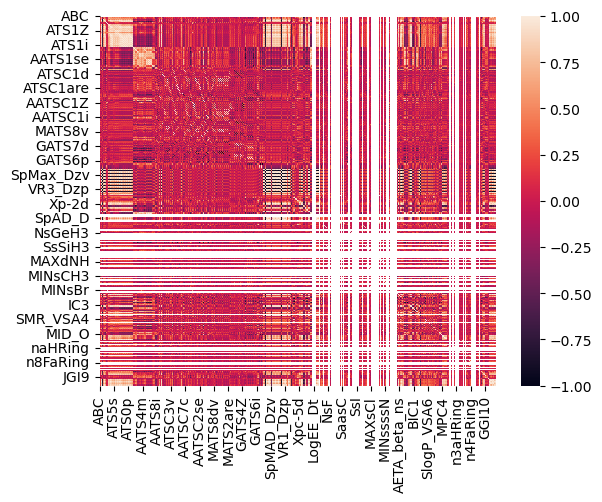

In [15]:
sns.heatmap(train_modred_descriptors.corr())

In [21]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold().set_output(transform="pandas")
X_high_variance = sel.fit_transform(train_modred_descriptors)

<AxesSubplot: >

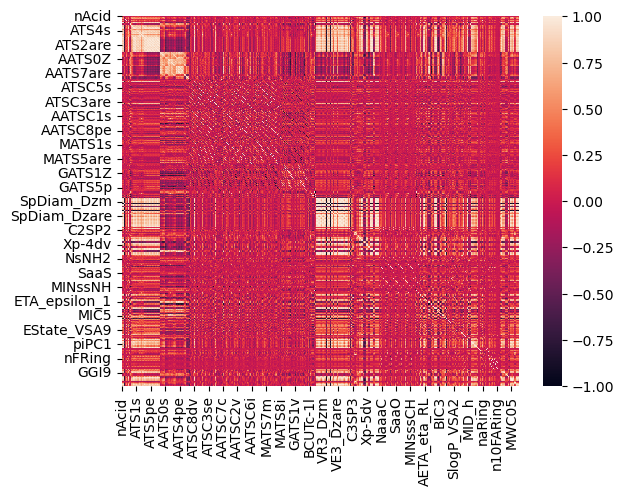

In [22]:
sns.heatmap(X_high_variance.corr())

- Tác giả có nói về việc sử dụng Pearson CC và Recursive features elimination để thực hiện việc lọc features. 
- Với Recursive features elimination, phần quan trọng nhất là thuật toán để kiểm tra và số lượng Features còn lại sau kiểm tra thì tác giả không nói rõ cho lắm.
- Tác giả có ý là "Following features/descriptors calculation, the descriptors
with all the values equal to null or zero, or with all the values less than 0.05, were removed." giá trị mà tác giả nhắc đến ở đây là giá trị p-values.
- Ở đây có thể tác giả dùng Backward Elimination trước rồi mới dùng Recursive features elimination và sau khi dùng 2 phương pháp đó, tác giả có 27 features cuối cùng có ảnh hưởng lớn nhất.
- Thay vì đó, em dùng thẳng Recursive Features Elimination luôn với đầu vào là 27 features và thuật toán để lọc là SVC (support vector classifier).

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
rf_clf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_clf.fit(X_high_variance, y_Train_des.reshape(len(y_Train_des)))

RandomForestClassifier(criterion='entropy', random_state=0)

In [24]:
model = SelectFromModel(estimator=rf_clf, prefit=True, max_features=27).set_output(transform="pandas")
X_Train_fs = model.fit_transform(X_high_variance)
X_Train_fs.columns

Index(['VR1_A', 'AATS5are', 'AATS8p', 'ATSC5dv', 'GATS8d', 'GATS4s', 'GATS4se',
       'GATS4are', 'BCUTp-1l', 'C1SP2', 'Xpc-4dv', 'NaaaC', 'SaaaC', 'SsNH2',
       'SssNH', 'SsOH', 'MAXsOH', 'MINaaaC', 'MINsOH', 'SMR_VSA3',
       'EState_VSA8', 'VSA_EState7', 'MDEN-22', 'MID_N', 'nFaRing', 'nFaHRing',
       'TopoPSA'],
      dtype='object')

<AxesSubplot: >

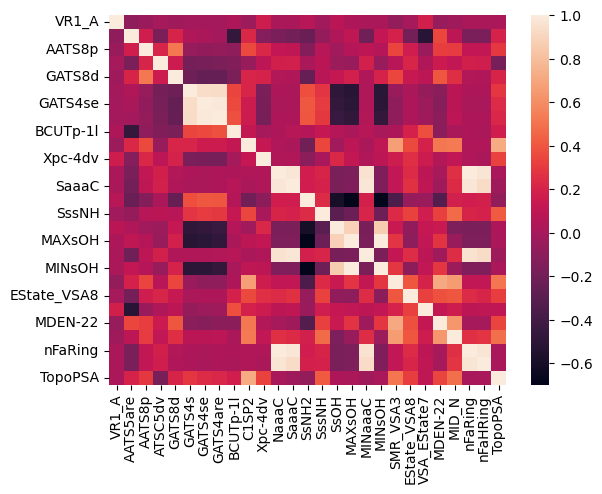

In [ ]:
sns.heatmap(X_Train_fs.corr())

__Tập dữ liệu đầu vào X của tác giả__

In [25]:
authors_features = ['Xc-4dv', 'MATS4s', 'GATS1dv', 'SdssC', 'BCUTd-1h', 'GATS1s', 'GATS1are', 'AATSC3d'
                    , 'PEOE_VSA2', 'AATS4v', 'AATS4Z', 'GATS3d', 'MATS3m', 'AXp-5dv', 'EState_VSA4',
                    'ETA_eta_L', 'ATSC5m', 'RotRatio', 'SsNH2', 'ETA_epsilon_5', 'SlogP_VSA2',
                    'MID_N', 'EState_VSA5', 'Xc-5dv', 'JGI5', 'GATS5pe', 'AATSC4d']
X_Train_author = pd.DataFrame()
for feature in authors_features:
    X_Train_author[feature] = train_modred_descriptors[feature] 
X_Train_author

,Xc-4dv,MATS4s,GATS1dv,SdssC,BCUTd-1h,GATS1s,GATS1are,AATSC3d,PEOE_VSA2,AATS4v,...,RotRatio,SsNH2,ETA_epsilon_5,SlogP_VSA2,MID_N,EState_VSA5,Xc-5dv,JGI5,GATS5pe,AATSC4d
0,-0.447261,0.292985,-0.058866,0.615022,-0.656446,0.204323,1.018310,0.061806,-0.677699,-0.924878,...,0.864410,1.322966,-0.718616,-0.675409,0.098390,-0.096634,-0.638191,-1.364336,1.011011,-1.428915
1,-0.447261,-0.652249,0.606157,0.669536,-0.656707,0.045503,1.732261,-0.245561,-0.677699,-1.199238,...,1.022937,1.320345,-1.214075,-0.675409,0.097795,-1.060276,-0.782210,-1.565814,1.073547,-0.634856
2,-0.447261,-0.728803,0.464603,-0.664624,-0.486493,-0.506911,-0.716330,-0.592661,0.475694,0.411823,...,-0.124302,-0.672586,-0.038948,0.286722,-0.598948,1.984608,-0.471512,-0.256063,-1.258880,-0.078281
3,-0.447261,0.804975,-0.723548,-0.096328,-0.580828,-0.463058,-0.880424,0.054962,-0.677699,-0.327936,...,1.159599,1.319317,0.628414,-0.536972,-0.662107,0.486673,-0.596891,-0.294531,0.235775,-1.140718
4,-0.447261,-0.157030,-0.615248,0.796326,-0.489896,-1.880264,-0.205679,0.925537,0.426239,-0.423056,...,1.022937,-0.672586,-0.615713,-0.186072,-0.560212,-1.060276,-0.825965,-0.856356,0.504730,-0.356526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,-0.189999,-2.075912,-1.027938,-0.412189,1.633176,0.762863,-0.887730,-1.002988,-0.586284,0.602728,...,-1.318948,-0.672586,2.518384,-0.867704,0.190451,0.436839,-0.630374,0.919239,-0.231271,0.648671
786,-0.447261,-0.409263,-0.349439,0.027203,-0.408647,-0.616589,-0.144352,0.254209,1.537671,-0.012365,...,0.915824,-0.672586,0.462663,0.384880,-0.532622,-1.060276,-0.334066,0.054580,-0.646175,0.237330
787,-0.447261,-0.658825,0.196075,-0.001587,-0.779460,-1.857554,-0.071192,0.328213,0.384278,-1.492985,...,1.419256,-0.672586,-0.690090,0.920292,-0.561096,-0.114474,-0.750844,-0.410839,0.756752,-0.252066
788,-0.447261,-0.456829,-0.793610,0.071609,-0.480986,-0.823378,-0.726188,1.398308,0.475694,-0.028809,...,0.662647,-0.672586,0.369979,-0.365240,0.977948,0.956847,-0.229620,-0.657698,-0.456429,1.692284


<AxesSubplot: >

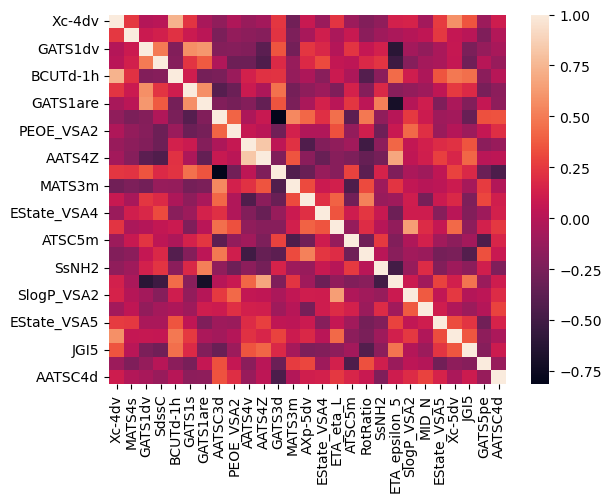

In [26]:
sns.heatmap(X_Train_author.corr())

__Principle component analysis__

In [ ]:
# from sklearn.decomposition import PCA
# pca_des = PCA(n_components=2)
# pca_author = PCA(n_components=2)
# my_X_Train_pca = pca_des.fit_transform(X_Train_des)
# author_X_Train_pca = pca_author.fit_transform(X_Train_author)

__TODO: Bổ sung sau__

### 2.2. Xây dựng mô hình

- Có 5 mô hình cần được xây dựng đó là Random Forest, K-nearest neighbors, SVM, XGBoost và Deep Neural Network. Nhưng vì chưa học đến phần Deep Learning, nên em tạm thời bỏ qua DNN.
- Các đặt tên của các mô hình sau sẽ là <tên mô hình>_<cách mã hóa>
- VD: rf_des, XGBoost_morgan2, ...

In [27]:
X_Train_fs.shape

(790, 27)

In [28]:
X_Train_author.shape

(790, 27)

In [29]:
y_Train_des.shape

(790,)

__Training by my data__

In [ ]:
X_Test_my_des = pd.DataFrame()
for feature in X_Train_fs.columns:
    X_Test_my_des[feature] = test_mordred_descriptors[feature]
X_Test_my_des

#### 2.2.1. Random Forest Classifier

__Train by my data__

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf_des = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_des.fit(X_Train_fs, y_Train_des.reshape(len(y_Train_des)))

RandomForestClassifier(criterion='entropy', random_state=0)

In [33]:
y_rf_des_pred = rf_des.predict(X_Test_my_des)

In [67]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_pred=y_rf_des_pred, y_true=y_Test_des)
print(cm)
rf_des_accuracy = accuracy_score(y_Test_des, y_rf_des_pred)
rf_des_ac_author = 0.798
print( "So sánh với độ chính xác của họ là " + str(rf_des_ac_author) +
      " thì độ lệnh là: " + 
      str((rf_des_ac_author-rf_des_accuracy)*100) )
rf_des_accuracy

[[ 41  18]
 [  8 131]]
So sánh với độ chính xác của họ là 0.798 thì độ lệnh là: -7.068686868686869


0.8686868686868687

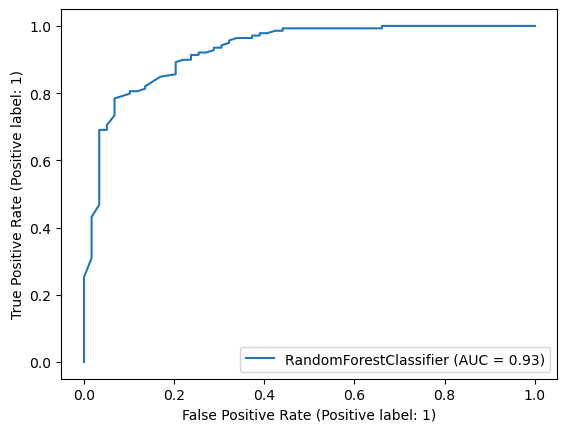

In [44]:
from sklearn.metrics import RocCurveDisplay
rf_morgan2_disp = RocCurveDisplay.from_estimator(rf_des, X_Test_my_des, y_Test_des)

__Training by author data__

In [56]:
X_Test_author_des = pd.DataFrame()
for feature in X_Train_author.columns:
    X_Test_author_des[feature] = test_mordred_descriptors[feature]
X_Test_author_des.shape
X_Test_author_des.columns

Index(['Xc-4dv', 'MATS4s', 'GATS1dv', 'SdssC', 'BCUTd-1h', 'GATS1s',
       'GATS1are', 'AATSC3d', 'PEOE_VSA2', 'AATS4v', 'AATS4Z', 'GATS3d',
       'MATS3m', 'AXp-5dv', 'EState_VSA4', 'ETA_eta_L', 'ATSC5m', 'RotRatio',
       'SsNH2', 'ETA_epsilon_5', 'SlogP_VSA2', 'MID_N', 'EState_VSA5',
       'Xc-5dv', 'JGI5', 'GATS5pe', 'AATSC4d'],
      dtype='object')

In [57]:
X_Train_author.columns

Index(['Xc-4dv', 'MATS4s', 'GATS1dv', 'SdssC', 'BCUTd-1h', 'GATS1s',
       'GATS1are', 'AATSC3d', 'PEOE_VSA2', 'AATS4v', 'AATS4Z', 'GATS3d',
       'MATS3m', 'AXp-5dv', 'EState_VSA4', 'ETA_eta_L', 'ATSC5m', 'RotRatio',
       'SsNH2', 'ETA_epsilon_5', 'SlogP_VSA2', 'MID_N', 'EState_VSA5',
       'Xc-5dv', 'JGI5', 'GATS5pe', 'AATSC4d'],
      dtype='object')

In [63]:
rf_des_author = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_des_author.fit(X_Train_author, y_Train_des.reshape(len(y_Train_des)))

RandomForestClassifier(criterion='entropy', random_state=0)

In [64]:
y_rf_des_author_pred = rf_des_author.predict(X_Test_author_des)

In [69]:
cm_author = confusion_matrix(y_pred=y_rf_des_author_pred, y_true=y_Test_des)
print(cm_author)
rf_des_author_accuracy = accuracy_score(y_Test_des, y_rf_des_author_pred)
rf_des_author_accuracy

[[ 40  19]
 [  7 132]]


0.8686868686868687

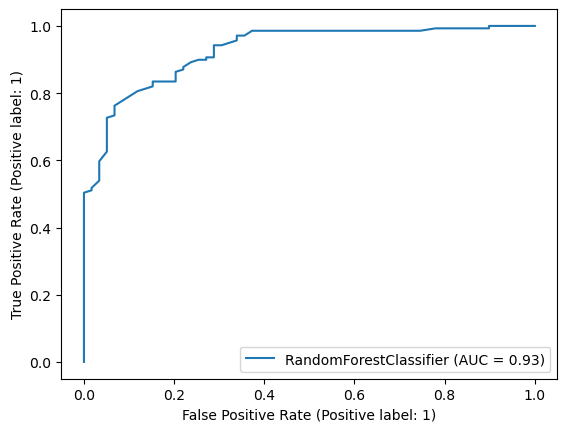

In [70]:
from sklearn.metrics import RocCurveDisplay
rf_morgan2_disp = RocCurveDisplay.from_estimator(rf_des_author, X_Test_author_des, y_Test_des)

#### 2.2.2. K-nearest neighbors

__Train by my data__

__Training by author data__